### Creating classification and segmentation (semantic) data

### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
import fastai; fastai.__version__

'1.0.55.dev0'

### inspect data

In [3]:
# main data path with full data
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()
# utils_path = path/'../input/siim-acr-pneumothorax-segmentation'

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [4]:
# define image paths
TRN_IMG_PATH = data_path/'dicom-images-train'
TEST_IMG_PATH = data_path/'dicom-images-test'

In [5]:
# get train and test dicom files
trn_files = get_files(TRN_IMG_PATH, extensions='.dcm', recurse=True)
test_files = get_files(TEST_IMG_PATH, extensions='.dcm', recurse=True)

In [6]:
# number of dicom files in train and test
len(trn_files), len(test_files)

(10712, 1377)

In [7]:
# let's check the structure of the dicom dataset by creating the following dataframe
def create_file_structure_df(files=trn_files):
    images_df = pd.DataFrame()
    images_df['study'] = [o.parent.parent.name for o in files]
    images_df['series'] = [o.parent.name for o in files]
    images_df['image_id'] = [o.stem for o in files]
    images_df['fname'] = files
    return images_df

In [8]:
# create for both train and test image files
trn_images_df = create_file_structure_df(trn_files)
test_images_df = create_file_structure_df(test_files)
trn_images_df.shape, test_images_df.shape

((10712, 4), (1377, 4))

In [9]:
# how many unique study, series and fname-image in training and test?
print(trn_images_df['study'].nunique(), trn_images_df['series'].nunique(), trn_images_df['fname'].nunique())
print(test_images_df['study'].nunique(), test_images_df['series'].nunique(), test_images_df['fname'].nunique())

10712 10712 10712
1377 1377 1377


In [10]:
# load train label df
trn_rle_df = pd.read_csv(data_path/'train-rle.csv')
trn_rle_df.shape, len(trn_rle_df.ImageId.unique())

((11582, 2), 10675)

In [11]:
# check if there is an associated image for each given label
assert len([img_id for img_id in trn_rle_df.ImageId if img_id not in trn_images_df.image_id.values]) == 0

In [12]:
# identify training image ids without any label
no_label_image_ids = [img_id for img_id in trn_images_df.image_id if img_id not in trn_rle_df.ImageId.values]
len(no_label_image_ids)

37

### from dicom data

In [13]:
import pydicom, PIL

In [14]:
# for fast look up and tidy code
trn_id2fname = dict(zip(trn_images_df['image_id'], trn_images_df['fname'].apply(lambda x: str(x))))
test_id2fname = dict(zip(test_images_df['image_id'], test_images_df['fname'].apply(lambda x: str(x))))

In [15]:
# show an image without label (without pneumothorax?)
fname = str(trn_id2fname[np.random.choice(no_label_image_ids)])
# meta information in a dicom object such as: age, gender, etc... can be used later in competition
dcm_obj = pydicom.read_file(fname); dcm_obj

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.2563.1517875173.431928
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '5f70c03f-a2a4-4a21-b77b-65009fb6b463'
(0010, 0020) Patient ID                          LO: '5f70c03f-a2a4-4a21-b77b-65009fb6b463'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [16]:
# convert .dcm to fastai Image
def dicom2tensor(fname):
    dcm_obj = pydicom.read_file(fname)
    pilimg = PIL.Image.fromarray(dcm_obj.pixel_array)
    pilimg = pilimg.convert('RGB') # 3 channel input - useful for pretrained models
    t = pil2tensor(pilimg, dtype=np.uint8)
    return t

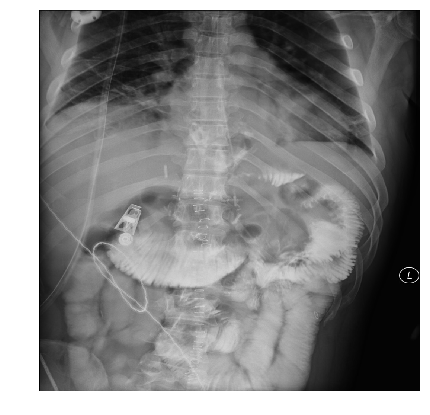

In [17]:
# plotting an image wihtout a label (without pneumothorax?)
t = dicom2tensor(fname); Image(t).show(figsize=(7,7))

In [18]:
# extract unique image ids with at least one label
unique_lbl_ids = trn_rle_df.ImageId.unique(); len(unique_lbl_ids)

10675

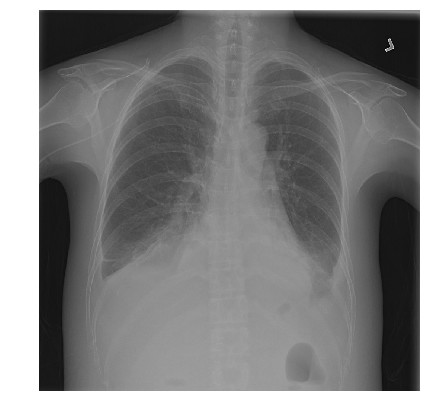

In [19]:
# show an image with pneumothorax label
image_id = np.random.choice(unique_lbl_ids)
fname = trn_id2fname[image_id]
t = dicom2tensor(fname); Image(t).show(figsize=(7,7))

In [20]:
# create label for the given image
trn_rle_df[trn_rle_df.ImageId.values == image_id]

,ImageId,EncodedPixels
10713,1.2.276.0.7230010.3.1.4.8323329.2343.151787517...,-1


In [21]:
# ratio of images without pneumothorax
(trn_rle_df[' EncodedPixels'] == ' -1').mean()

0.7162838887929546

In [22]:
# here we see that label ' -1' is used for non-pneumothorax images, so we can add other images too
_trn_rle_df = pd.concat([trn_rle_df, pd.DataFrame({'ImageId':no_label_image_ids, ' EncodedPixels': ' -1'})])

In [23]:
# check if all labels have an image and vice-versa
assert np.all(set(_trn_rle_df.ImageId.unique()) == set(trn_images_df.image_id.unique()))
trn_rle_df = _trn_rle_df

In [24]:
# save new train label csv
trn_rle_df.to_csv("train-rle.csv", index=False)

### save image-mask 

In [25]:
# sys.path.append(str(utils_path))
from mask_functions import *

In [26]:
os.makedirs("images", exist_ok=True); image_path = Path("images")
os.makedirs("masks", exist_ok=True); mask_path = Path("masks")

In [27]:
image_path, mask_path

(PosixPath('images'), PosixPath('masks'))

In [28]:
# convert .dcm to fastai Image
def dicom2pil(fname):
    dcm_obj = pydicom.read_file(fname)
    pilimg = PIL.Image.fromarray(dcm_obj.pixel_array)
    pilimg = pilimg.convert('RGB') # 3 channel input - useful for pretrained models
    return pilimg

In [29]:
# label dataframe
trn_rle_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [30]:
# train and test image ids
trn_image_ids = np.array(list(trn_id2fname.keys()))
test_image_ids = np.array(list(test_id2fname.keys()))

In [31]:
len(trn_image_ids), len(test_image_ids)

(10712, 1377)

In [32]:
def masks2img(masks):
    "combine list of binary masks, handle overlap"
    masks_summed = np.clip(np.stack(masks).sum(0), 0, 255)
    maskimg = (PIL.Image.fromarray(masks_summed.astype(np.uint8)).transpose(PIL.Image.TRANSPOSE))
    return maskimg

In [106]:
def save_trn_image_mask(image_id, _):
    "save train image and labels"
    sz, path = 448, data_path
    # create image dirs
    os.makedirs(path/"train", exist_ok=True)
    os.makedirs(path/f"train/images_{sz}", exist_ok=True); image_path = Path(path/f"train/images_{sz}")
    os.makedirs(path/f"train/masks_{sz}", exist_ok=True); mask_path = Path(path/f"train/masks_{sz}")
   
    # read dicom to pil
    pilimg = dicom2pil(trn_id2fname[image_id])
    
    # get rle label and convert to mask
    rles = trn_rle_df[trn_rle_df.ImageId == image_id][' EncodedPixels'].values
    if len(rles) == 1 and rles == [' -1']: masks = None
    else: masks = [rle2mask(rle, *pilimg.size).astype(np.uint8) for rle in rles]
    
    # resize image and mask and save
    pilimg_rszd = pilimg.resize((sz,sz), resample=PIL.Image.BILINEAR)
    pilimg_rszd.save(f"{image_path/image_id}.jpg", format='JPEG')
    if masks is not None: 
        assert np.all(np.unique(masks) == np.array([0, 255]))
        maskimg = masks2img(masks)
        maskimg_rszd = maskimg.resize((sz,sz), resample=PIL.Image.NEAREST)
        maskimg_rszd.save(f"{mask_path/image_id}.png", format='PNG')


In [107]:
# save all training images and masks ~ 20 SECONDS
parallel(func=save_trn_image_mask, arr=trn_image_ids, max_workers=40, leave=True)

In [108]:
sz=448
image_path, mask_path = Path(data_path/f"train/images_{sz}"), Path(data_path/f"train/masks_{sz}")

In [109]:
image_path, mask_path

(PosixPath('../../data/siim_acr_pneu/train/images_448'),
 PosixPath('../../data/siim_acr_pneu/train/masks_448'))

In [110]:
def save_test_image(image_id, _):
    "save test image"
    sz, path = 448, data_path
    # create image dirs
    os.makedirs(path/"test", exist_ok=True)
    os.makedirs(path/f"test/images_{sz}", exist_ok=True); image_path = Path(path/f"test/images_{sz}")
   
    # read dicom to pil
    pilimg = dicom2pil(test_id2fname[image_id])
        
    # resize image and mask and save
    pilimg_rszd = pilimg.resize((sz,sz), resample=PIL.Image.BILINEAR)
    pilimg_rszd.save(f"{image_path/image_id}.jpg", format='JPEG')
    

In [111]:
# save all test images
parallel(save_test_image, test_image_ids, max_workers=40)

In [112]:
test_image_path = Path(data_path/f"test/images_{sz}")

In [113]:
test_image_path

PosixPath('../../data/siim_acr_pneu/test/images_448')

### show

In [114]:
id2image_fname = {o.stem:o for o in image_path.ls()}
id2mask_fname = {o.stem:o for o in mask_path.ls()}

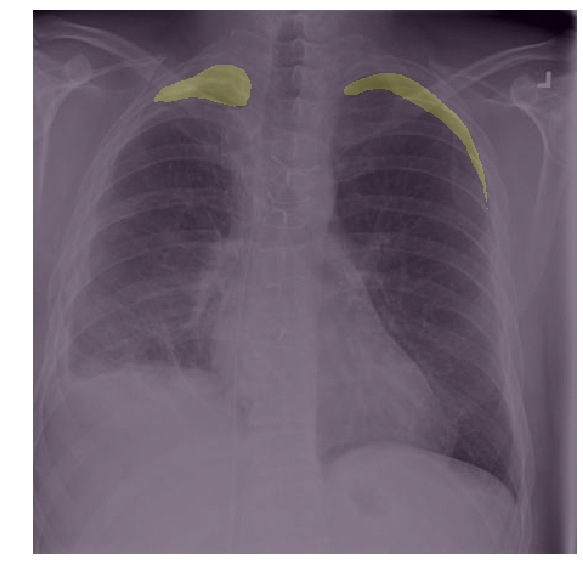

In [115]:
_id = np.random.choice(list(id2mask_fname.keys()))
fig,ax=plt.subplots(1,1,figsize=(10,10))
open_image(id2image_fname[_id]).show(ax=ax)
open_mask(id2mask_fname[_id], div=True).show(ax=ax,alpha=0.2,cmap='viridis')

### classification

In [66]:
# clas_df = pd.DataFrame()
# clas_df['ImageId'] = trn_rle_df['ImageId']
# clas_df['target'] = trn_rle_df[' EncodedPixels'].apply(lambda x: 1 if x == ' -1' else 0)

# clas_df.to_csv(data_path/'clas_df.csv', index=False)

# clas_df.target.mean()